------------------------------------------
| | |
|:----------|:----------|
| Name      | Bayesian Modeling |
| Notebook  |  Effect of different priors|
| Notes | Ad Example: Probability of Success of Ad Campaign| 
| Author    | Joshuah Touyz, PhD |
| Version   | 0.1 |
|Last update| 05/29/20 |
-------------------------------------------------

In [5]:
# Load librarires
import numpy as np
import scipy.stats as sc
import plotnine as pn
import pandas as pd

# Plot configurations
pn.options.figure_size = (15,4)
pn.options.dpi = 125

In [6]:
### Setting up prior ###
# Generate a random value from a beta distribution
beta_prior = lambda a ,b, size: np.random.beta(a ,b, size = size)

### Setting data generating process ###
likelihood = lambda x,n,theta: sc.binom.pmf(k = x, n= n, p = theta)

### Posterior distribution ###
# Directly generate a sample from the posterior distribution
beta_posterior = lambda a ,b,n,x,size: beta_prior(a+x, b+n-x, size)

### Beta probability ###
beta_prob = lambda theta,a ,b: sc.beta.pdf(theta,a ,b)

In [7]:
########################
### Different priors ###
########################
thetas_in = np.arange(0.01,1-0.01,1/1000)

# -- Flat prior (uniform) --
a_f = 1 ; b_f = 1 
flat_prior = beta_prob(thetas_in, a_f, b_f)

# -- Jeffrey's Prior --
a_j = 0.5 ; b_j = 0.5 
jeffreys_prior = beta_prob(thetas_in, a_j, b_j)

# -- Informed prior --
a_i = 5; b_i = 10
informed_prior = beta_prob(thetas_in, a_i, b_i)


# Setting up the dataframe
prior_distributions = pd.DataFrame({'Theta':thetas_in,
                                    'Flat Prior': flat_prior,
                                    'Informed Prior': informed_prior,
                                    'Jeffreys Prior': jeffreys_prior})
prior_distributions

,Theta,Flat Prior,Informed Prior,Jeffreys Prior
0,0.010,1.0,9.144308e-05,3.199135
1,0.011,1.0,1.326696e-04,3.051797
2,0.012,1.0,1.861965e-04,2.923351
3,0.013,1.0,2.541335e-04,2.810088
4,0.014,1.0,3.387181e-04,2.709241
...,...,...,...,...
975,0.985,1.0,3.622433e-13,2.618704
976,0.986,1.0,1.954763e-13,2.709241
977,0.987,1.0,1.007379e-13,2.810088
978,0.988,1.0,4.921450e-14,2.923351


In [8]:
# Reformatting the dataframe for plotting
prior_distributions = prior_distributions.set_index('Theta').stack().reset_index().rename({'level_1':'Prior Type',0:'Values'},axis =1)
prior_distributions


,Theta,Prior Type,Values
0,0.010,Flat Prior,1.000000e+00
1,0.010,Informed Prior,9.144308e-05
2,0.010,Jeffreys Prior,3.199135e+00
3,0.011,Flat Prior,1.000000e+00
4,0.011,Informed Prior,1.326696e-04
...,...,...,...
2935,0.988,Informed Prior,4.921450e-14
2936,0.988,Jeffreys Prior,2.923351e+00
2937,0.989,Flat Prior,1.000000e+00
2938,0.989,Informed Prior,2.258153e-14


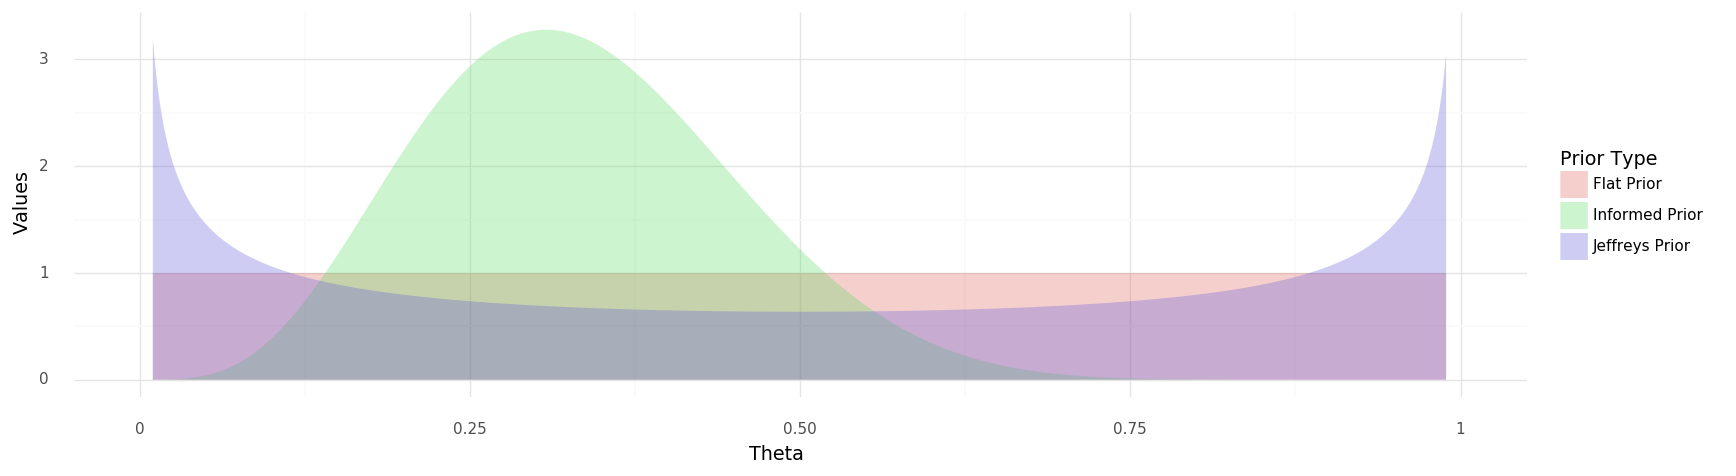

<ggplot: (-9223372036522445424)>

In [9]:
pn.ggplot(pn.aes(x = 'Theta', y = 'Values', fill = 'Prior Type'), data = prior_distributions)\
                + pn.geom_area(size = 1.5, alpha = 0.3, position = 'identity')\
                + pn.theme_minimal()\
                + pn.xlim([0,1])

In [10]:
################################
### Generating the posterior ###
################################

# Constants
n_samples = 1000
alpha = 5 ; beta = 10
X = 15 ; n = 35
delta = 0.05
def beta_binomial_posterior(X,n, a, b, delta = 0.02, plot_only = True):
    
    # -- Generating the posterior --
    # Generating a random distribution of thetas 
    thetas = list(np.arange(delta,1,delta))
    pi_thetas = beta_prob(thetas, a, b)

    # Calculating the likelihood
    X_given_theta = likelihood(x = X, n = n, theta = thetas)

    # Posterior distribution 
    normalizing_constant  = np.sum(pi_thetas * X_given_theta)
    posterior_distribution  = (X_given_theta * pi_thetas) / normalizing_constant

    # Normalizing prior and likelihood for plotting
    density_likelihood = X_given_theta/np.sum(X_given_theta)
    density_pi_theta = pi_thetas/np.sum(pi_thetas)

    # -- Setting up the dataframe for plotting --
    # Setting up values
    labels = ['Density Prior Pr(theta)','Density Likelihood Pr(X|theta)','Posterior Distribution Pr(theta|x)']
    density_values = [density_pi_theta, density_likelihood, posterior_distribution]

    # Setting up the dataframe
    df_posterior = pd.DataFrame(dict(zip(['thetas'] + labels, [thetas] + density_values)))
    # Re-formatting the data for plotting
    df_posterior = df_posterior.set_index('thetas').stack().reset_index().rename({'level_1':'Distributions',0:'Values'},axis = 1)

    # Plot the prior, posterior and likelihood
    y_max = np.array(density_values).flatten().max() # for plotting
    colors = ['#BED5E5','#BAE393','#686868']

    plot_out = (pn.ggplot(pn.aes(x = 'thetas', y = 'Values', color = 'Distributions', fill = 'Distributions'), data = df_posterior)\
                + pn.geom_area(size = 1.5, alpha = 0.3, position = 'identity')\
                + pn.scale_color_manual(dict(zip(labels,colors)))\
                + pn.scale_fill_manual(dict(zip(labels,colors)))\
                + pn.ylab('Normalized density')\
                + pn.theme_minimal()\
                + pn.xlim([0,1])\
                + pn.ylim([0, y_max]))
    if plot_only:
        return(plot_out)
    else:
        retun({'Densities':df_posterior, 'Plot':plot_out})

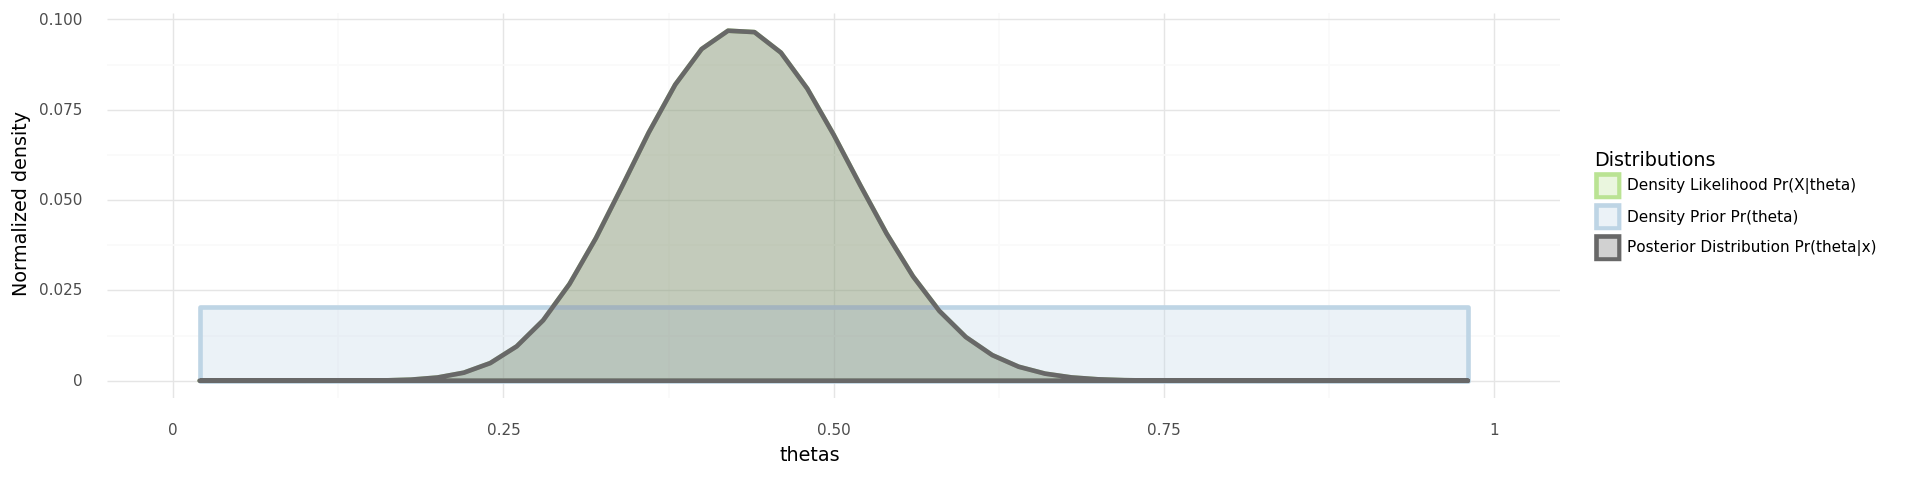

<ggplot: (-9223372036522445333)>

In [11]:
# Flat prior
beta_binomial_posterior(X,n,a_f,b_f,delta = 0.02)

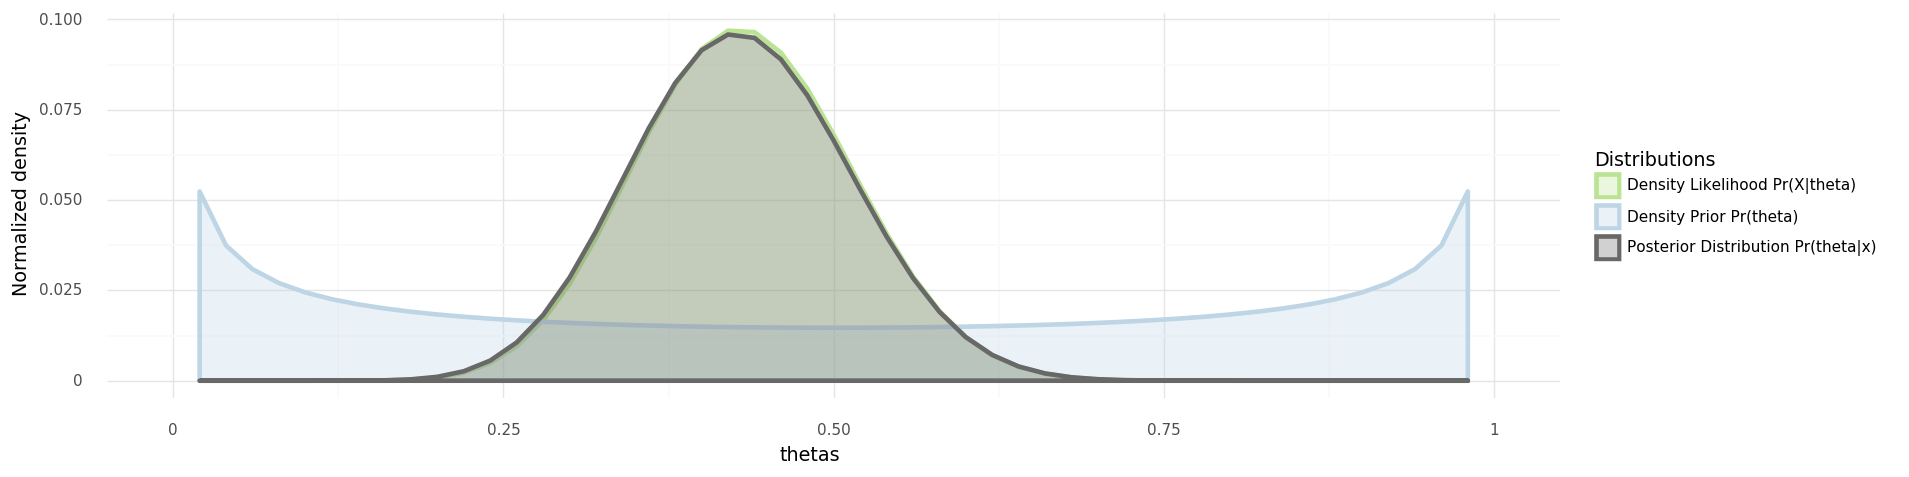

<ggplot: (334585783)>

In [12]:
# Jeffreys prior
beta_binomial_posterior(X,n,a_j,b_j,delta = 0.02)

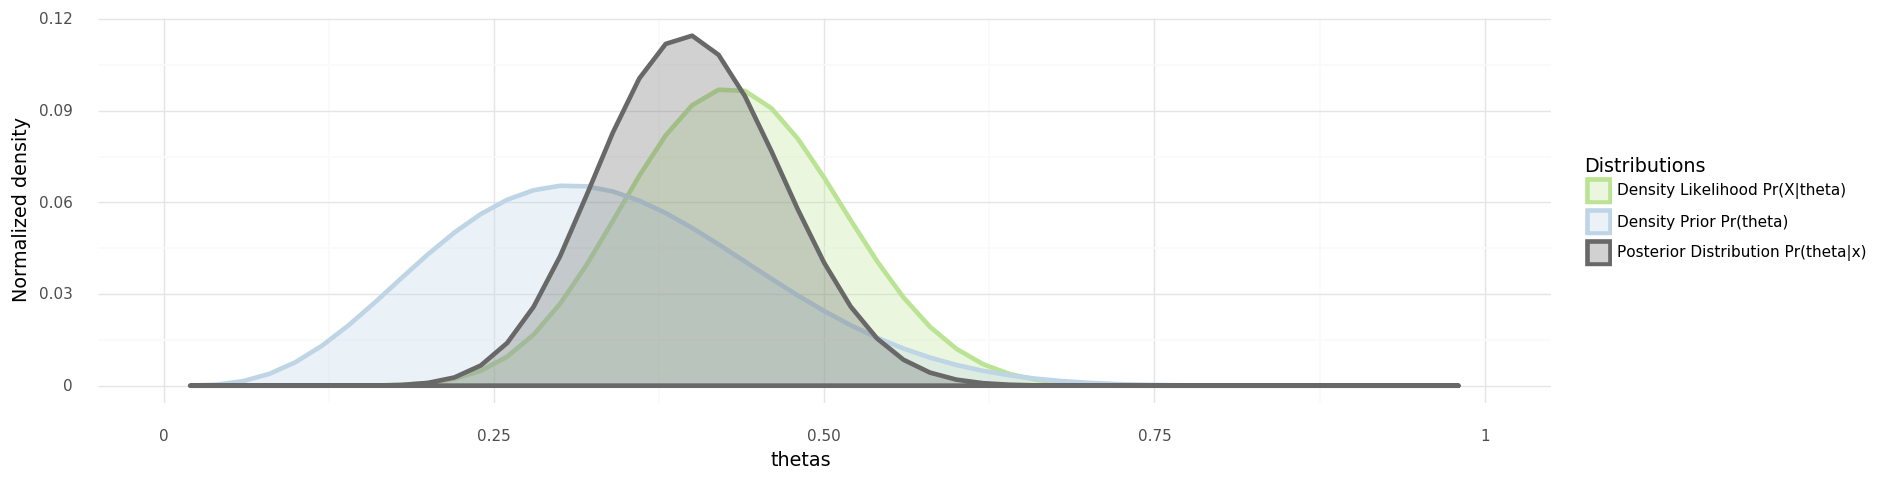

<ggplot: (334589353)>

In [13]:
# Informed prior
X = 15 ; n = 35; n_samples = 1000
beta_binomial_posterior(X,n,a_i,b_i,delta = 0.02)

Let's consider what happends when the number of data generated increses

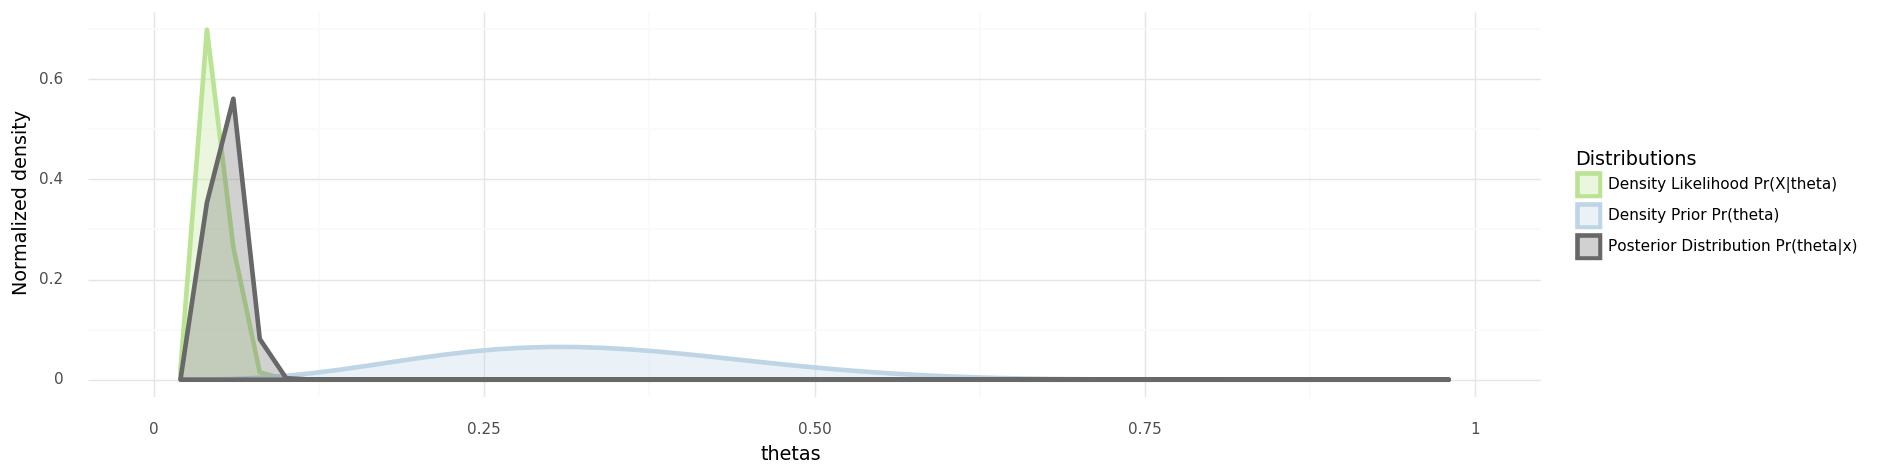

<ggplot: (334709775)>

In [15]:
# Informed prior
how_much_more_data = 10
beta_binomial_posterior(X ,
                        n * how_much_more_data,
                        a_i, b_i,delta = 0.02)